# Daniele Sindaco 0001139535

# FRUIT INSPECTION

Students should develop a software system aimed at locating defects and imperfections on fruits. Each fruit is acquired 
through a NIR (Near Infra-Red) and a color camera with little parallax effect. 
The image name format is Cx_yyyyyy.bmp, where x is 0 for the NIR images and 1 for the color images, while yyyyyy is the 
incremental number of the pair. 

## FIRST TASK: FRUIT SEGMENTATION AND DEFECT DETECTION 

Images in folder “first task” show three apples with clear external defects.
Students should: 
- Outline the fruit by generating a binary mask. <br>
HINT: first threshold the whole image in order to remove the background, but keeping intact the fruit borders; then 
fill the holes inside the fruit blob using a flood-fill approach. The image pair has little parallax, so a mask might be 
computed on one image and then applied on the other one. 
- Search for the defects on each fruit. <br>
HINT: the defects have strong edges, so edge extraction algorithm should help. Also, they usually exhibit a far 
darker color with respect to the neighboring areas of the fruit.

#### 1. Outline the fruit by generating a binary mask.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

First of all, we visualize the images with their respective gray-level histogram.

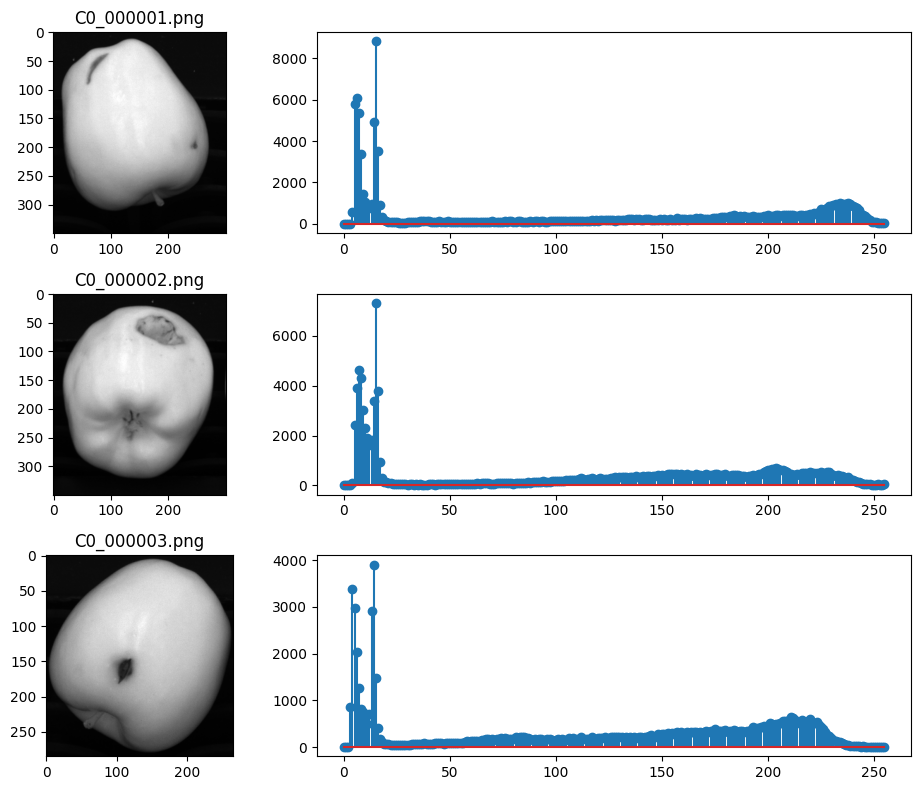

In [2]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 1.5]})

for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(img, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist)
    plt.tight_layout()

plt.show()    

We try to create a binary mask using Otsu's algorithm. This algorithm identifies two maximally homogeneous regions and selects a threshold value between them to optimally separate the regions. The threshold is chosen so as to minimize across the gray-level range the Within-group Variance of the resulting regions, expressed as: <br>
$$ \sigma_w^2 = q_1 \sigma_1^2 + q_2 \sigma_2^2$$ <br>
with $q_1 = \sum_{i=1}^t p(i)$ and $q_2 = \sum_{i=t+1}^L p(i)$ that represent the probability of a pixel being in a region and the two sigmas that represent the variance of the regions. <br>
Within-group Variance measures how spread turn out region intensities upon binarization by a given gray-level.

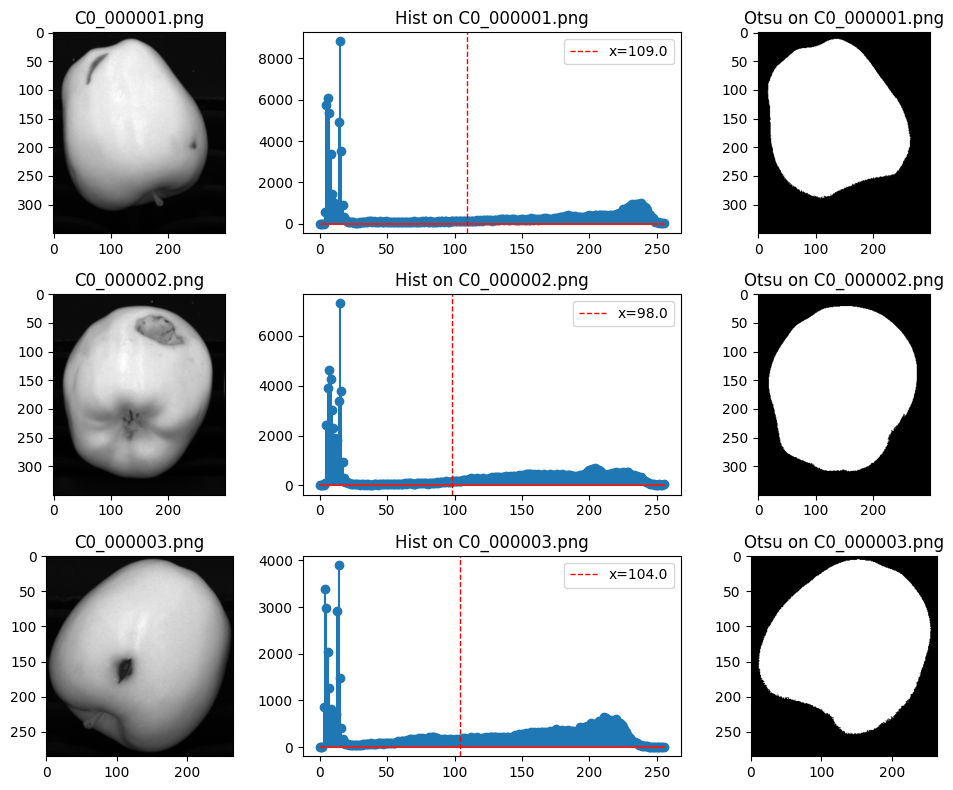

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 1.5, 1]})

for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    #Apply Otsu's algorithm
    ret,th = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #Flood-fill the background with 255 (white)
    th_copy = th.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th_copy, mask, (0,0), 255)

    #Fill internal holes by overlapping results
    th_final = np.maximum(th, cv2.bitwise_not(th_copy))

    #Histogram
    hist, bins = np.histogram(img.flatten(), 256, [0,256])
    
    #Plot images
    axs[i, 0].imshow(img, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist), axs[i, 1].axvline(x=ret, color='r', linestyle='--', linewidth=1, label=f'x={ret}'), axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png"), axs[i, 1].legend()
    axs[i, 2].imshow(th_final, cmap='gray'), axs[i, 2].set_title(f"Otsu on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

We can smooth the edges by applying a GaussianBlur filter.

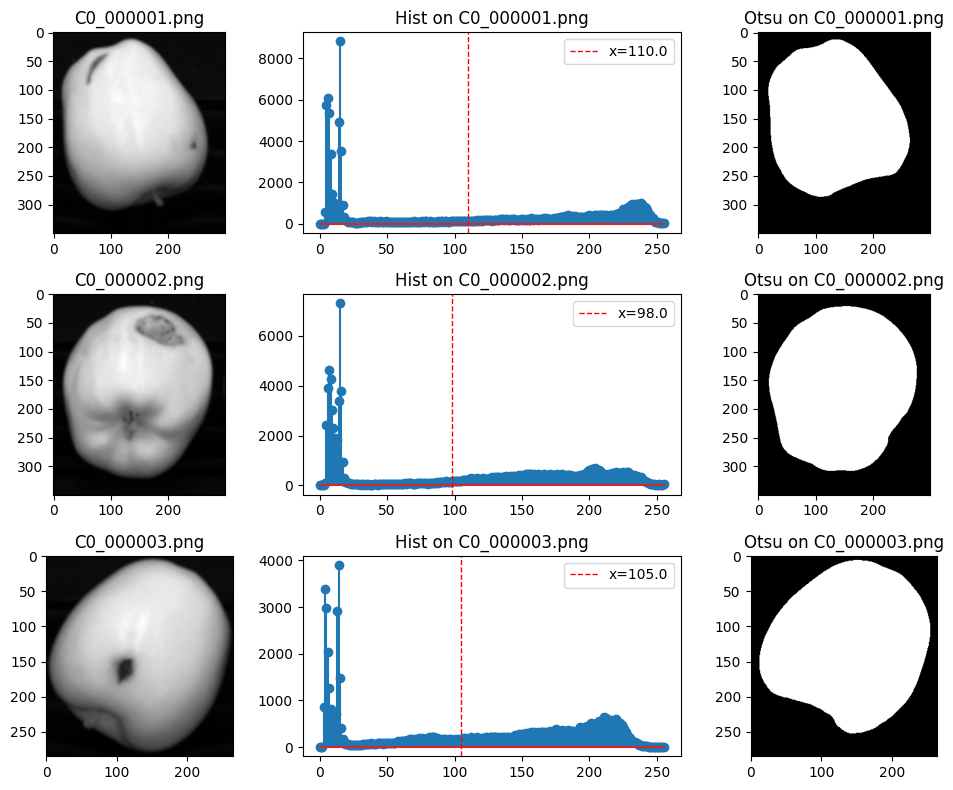

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 1.5, 1]})

for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    #Blur the image in order to smooth the border
    g_blur = cv2.GaussianBlur(img,(9,9),0)

    #Apply Otsu's algorithm
    ret,th = cv2.threshold(g_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #Flood-fill the background with 255 (white)
    th_copy = th.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th_copy, mask, (0,0), 255)

    #Fill internal holes by overlapping results
    th_final = np.maximum(th, cv2.bitwise_not(th_copy))
    
    #Histogram
    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    #Plot images
    axs[i, 0].imshow(g_blur, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist), axs[i, 1].axvline(x=ret, color='r', linestyle='--', linewidth=1, label=f'x={ret}'), axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png"), axs[i, 1].legend()
    axs[i, 2].imshow(th_final, cmap='gray'), axs[i, 2].set_title(f"Otsu on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

Another solution is to apply an adaptive threshold, which works better when the image has non-uniform lighting. Adaptive thresholding methods compute a binarization threshold for each pixel based on the intensities within a small neighbourhood. In the OpenCV function, we can choose the size of the neighbourhood and the constant value to be subtracted from the local mean of pixel intensities around each pixel. This allows us to lower the threshold and thus classify some darker pixels as foreground. OpenCV offers 2 methods to calculate the threshold: <br>
1. cv2.ADAPTIVE_THRESH_MEAN_C: The threshold value is the mean of the neighbourhood area minus the constant C.
2. cv2.ADAPTIVE_THRESH_GAUSSIAN_C: The threshold value is a gaussian-weighted sum of the neighbourhood values minus the constant C.

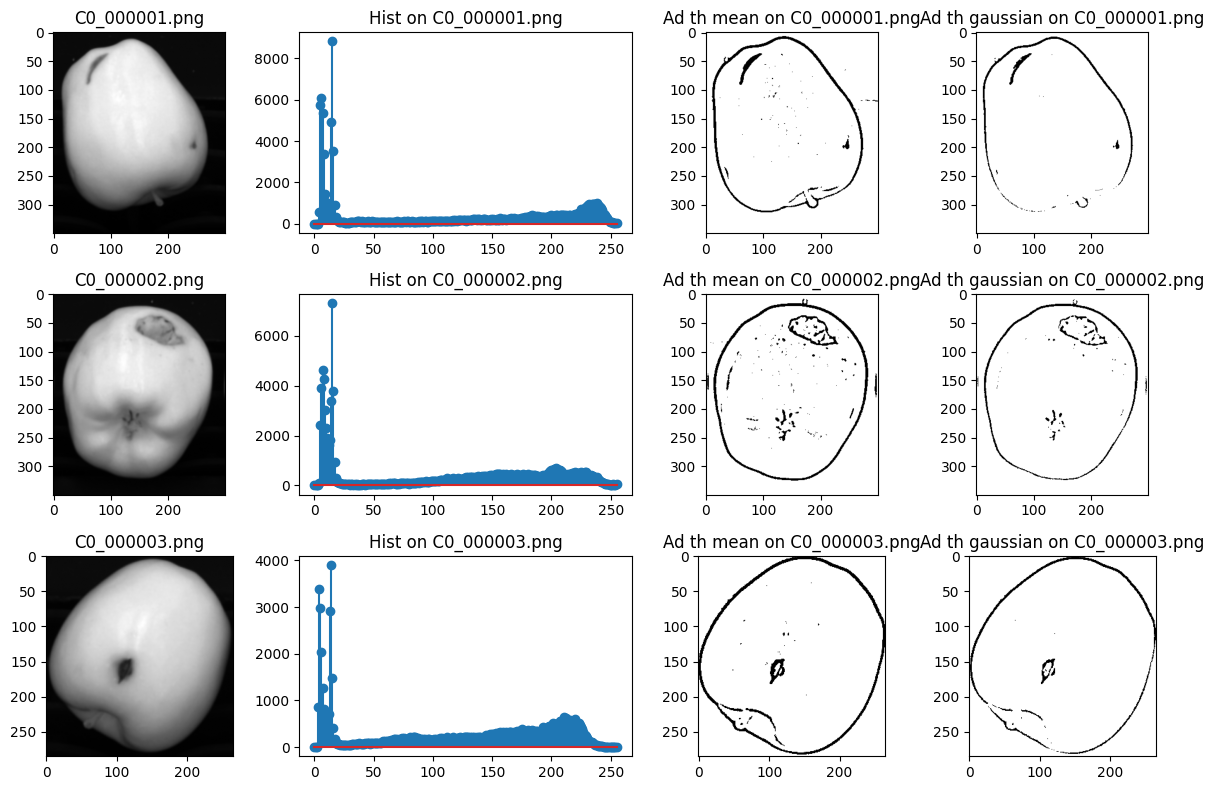

In [9]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5, 1, 1]})

for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    blur = cv2.bilateralFilter(img,5,75,75)
    th1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,7,3)
    th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,7,3)

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(blur, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist), axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png")
    axs[i, 2].imshow(th1, cmap='gray'), axs[i, 2].set_title(f"Ad th mean on C0_00000{i+1}.png")
    axs[i, 3].imshow(th2, cmap='gray'), axs[i, 3].set_title(f"Ad th gaussian on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

Since adaptive thresholding is suitable for text images where many neighbourhoods contain mostly background pixels, it mainly detects edges. To segment the fruit instead, we can use a larger neighbourhood and adjust the constant to lower the threshold, allowing darker pixels that still belong to the fruit to be included.

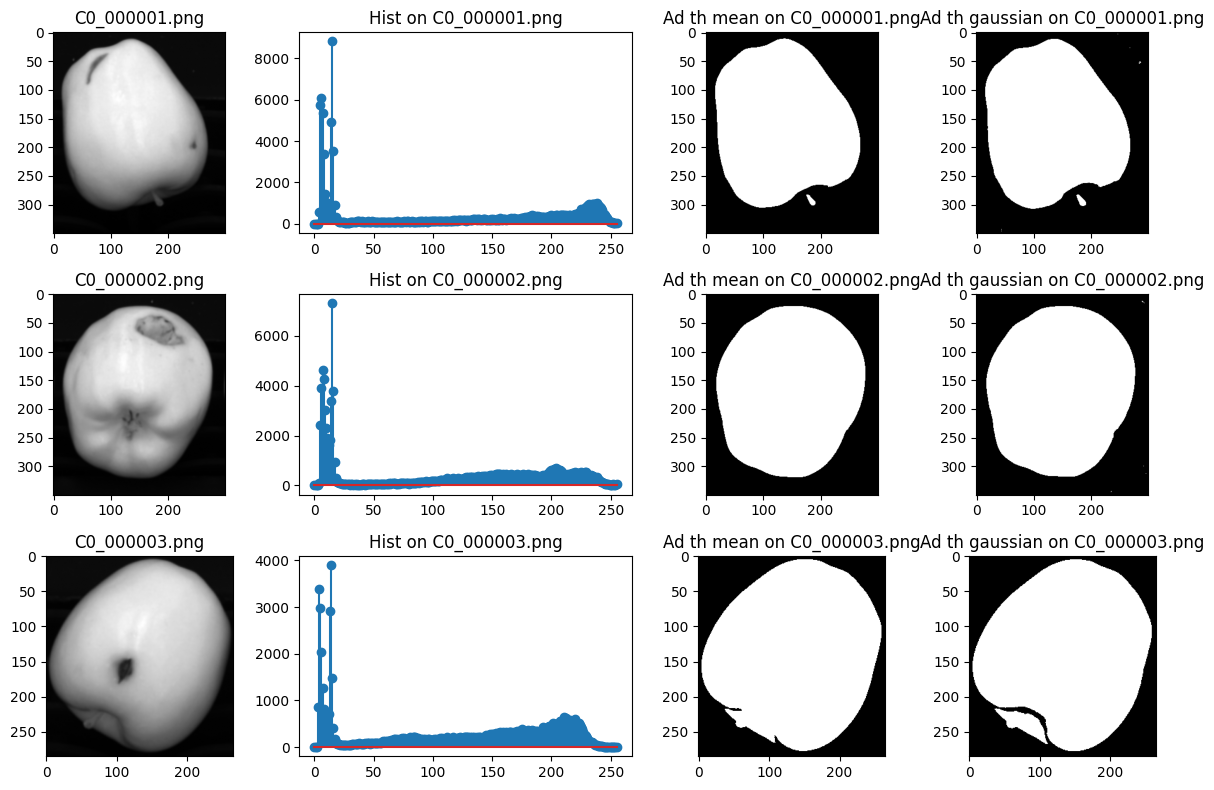

In [10]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5, 1, 1]})

for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    blur = cv2.bilateralFilter(img,5,75,75)
    th1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,303,9)
    th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,303,9)

    #fill background
    th1 = np.pad(th1, 1, mode='constant', constant_values=255)
    cv2.floodFill(th1, None, (0, 0), 0)
    th1 = th1[1:-1, 1:-1]

    th2 = np.pad(th2, 1, mode='constant', constant_values=255)
    cv2.floodFill(th2, None, (0, 0), 0)
    th2 = th2[1:-1, 1:-1]

    #Flood-fill the background with 255 (white)
    th1_copy = th1.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th1_copy, mask, (0,0), 255)

    th2_copy = th2.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th2_copy, mask, (0,0), 255)

    #Fill internal holes by overlapping results
    th1_final = np.maximum(th1, cv2.bitwise_not(th1_copy))
    th2_final = np.maximum(th2, cv2.bitwise_not(th2_copy))

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(blur, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist), axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png")
    axs[i, 2].imshow(th1_final, cmap='gray'), axs[i, 2].set_title(f"Ad th mean on C0_00000{i+1}.png")
    axs[i, 3].imshow(th2_final, cmap='gray'), axs[i, 3].set_title(f"Ad th gaussian on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

Adaptive thresholding produced better result. We now use the binary mask to visualize the fruits without the background.

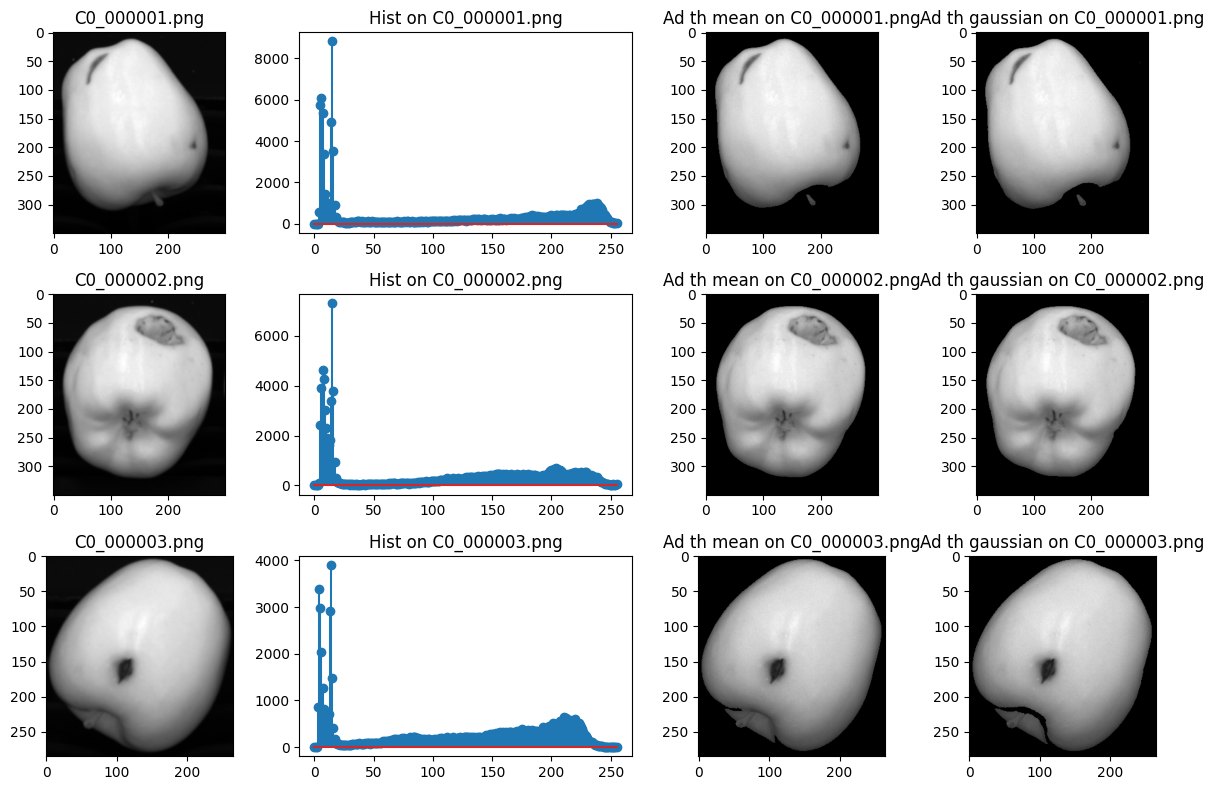

In [11]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5, 1, 1]})

for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    blur = cv2.bilateralFilter(img,5,75,75)
    th1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,303,9)
    th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,303,9)

    #fill background
    th1 = np.pad(th1, 1, mode='constant', constant_values=255)
    cv2.floodFill(th1, None, (0, 0), 0)
    th1 = th1[1:-1, 1:-1]

    th2 = np.pad(th2, 1, mode='constant', constant_values=255)
    cv2.floodFill(th2, None, (0, 0), 0)
    th2 = th2[1:-1, 1:-1]

    #Flood-fill the background with 255 (white)
    th1_copy = th1.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th1_copy, mask, (0,0), 255)

    th2_copy = th2.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th2_copy, mask, (0,0), 255)

    #Fill internal holes by overlapping results
    th1_final = np.maximum(th1, cv2.bitwise_not(th1_copy))
    th2_final = np.maximum(th2, cv2.bitwise_not(th2_copy))

    fruit_only1 = cv2.bitwise_and(img, img, mask=th1_final)
    fruit_only2 = cv2.bitwise_and(img, img, mask=th2_final)

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(blur, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist), axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png")
    axs[i, 2].imshow(fruit_only1, cmap='gray'), axs[i, 2].set_title(f"Ad th mean on C0_00000{i+1}.png")
    axs[i, 3].imshow(fruit_only2, cmap='gray'), axs[i, 3].set_title(f"Ad th gaussian on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

Here we visualize the three solutions analyzed before.

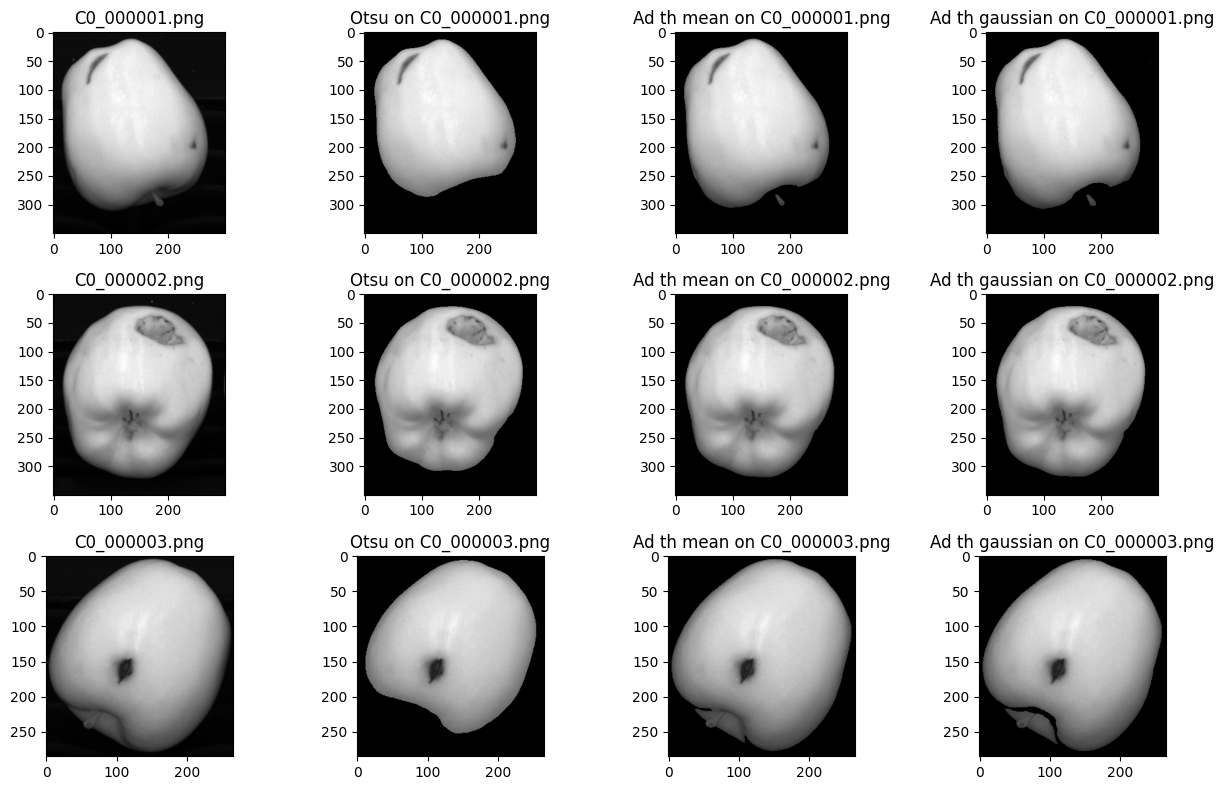

In [12]:
fig, axs = plt.subplots(3, 4, figsize=(13, 8), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

th_final_arr = []
th1_final_arr = []
th2_final_arr = []

for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    #Apply Otsu's algorithm
    g_blur = cv2.GaussianBlur(img,(9,9),0)
    ret,th = cv2.threshold(g_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #Apply adaptive thresholds
    blur = cv2.bilateralFilter(img,5,75,75)
    th1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,303,9)
    th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,303,9)

    #fill background
    th = np.pad(th, 1, mode='constant', constant_values=255)
    cv2.floodFill(th, None, (0, 0), 0)
    th = th[1:-1, 1:-1]
    
    th1 = np.pad(th1, 1, mode='constant', constant_values=255)
    cv2.floodFill(th1, None, (0, 0), 0)
    th1 = th1[1:-1, 1:-1]

    th2 = np.pad(th2, 1, mode='constant', constant_values=255)
    cv2.floodFill(th2, None, (0, 0), 0)
    th2 = th2[1:-1, 1:-1]

    #Flood-fill the background with 255 (white)
    th_copy = th.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th_copy, mask, (0,0), 255)
    
    th1_copy = th1.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th1_copy, mask, (0,0), 255)

    th2_copy = th2.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th2_copy, mask, (0,0), 255)

    #Fill internal holes by overlapping results
    th_final = np.maximum(th, cv2.bitwise_not(th_copy))
    th1_final = np.maximum(th1, cv2.bitwise_not(th1_copy))
    th2_final = np.maximum(th2, cv2.bitwise_not(th2_copy))

    fruit_only = cv2.bitwise_and(img, img, mask=th_final)
    fruit_only1 = cv2.bitwise_and(img, img, mask=th1_final)
    fruit_only2 = cv2.bitwise_and(img, img, mask=th2_final)

    th_final_arr.append(th_final)
    th1_final_arr.append(th1_final)
    th2_final_arr.append(th2_final)
    
    #Print images
    axs[i, 0].imshow(img, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(fruit_only, cmap='gray'), axs[i, 1].set_title(f"Otsu on C0_00000{i+1}.png")
    axs[i, 2].imshow(fruit_only1, cmap='gray'), axs[i, 2].set_title(f"Ad th mean on C0_00000{i+1}.png")
    axs[i, 3].imshow(fruit_only2, cmap='gray'), axs[i, 3].set_title(f"Ad th gaussian on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

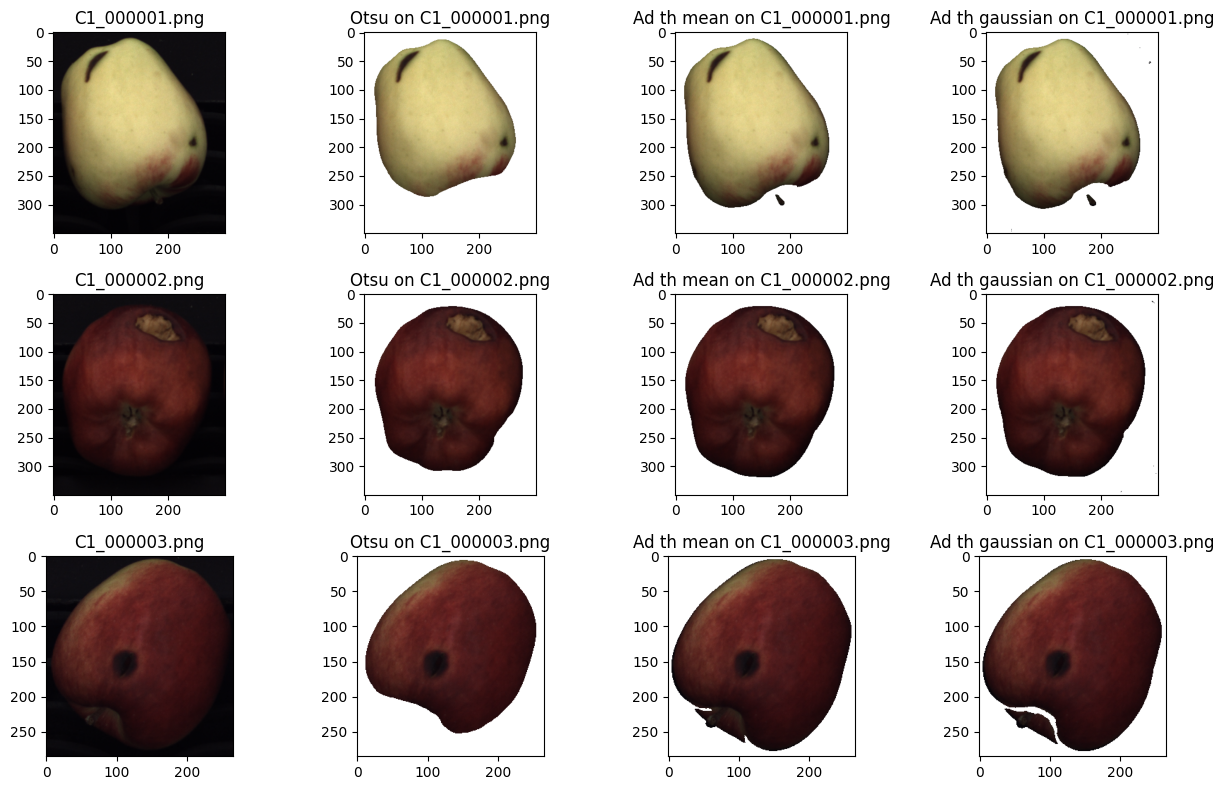

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(13, 8), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

for i in range(3):
    path = f'./fruit-inspection-images/first task/C1_00000{i+1}.png'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mat = np.ones_like(img)*255
    
    #Apply the mask to the original image 
    fruit_only = cv2.bitwise_not(cv2.bitwise_and(mat, cv2.bitwise_not(img), mask=th_final_arr[i]))
    fruit_only1 = cv2.bitwise_not(cv2.bitwise_and(mat, cv2.bitwise_not(img), mask=th1_final_arr[i]))
    fruit_only2 = cv2.bitwise_not(cv2.bitwise_and(mat, cv2.bitwise_not(img), mask=th2_final_arr[i]))

    #Print images
    axs[i, 0].imshow(img), axs[i, 0].set_title(f"C1_00000{i+1}.png")
    axs[i, 1].imshow(fruit_only), axs[i, 1].set_title(f"Otsu on C1_00000{i+1}.png")
    axs[i, 2].imshow(fruit_only1), axs[i, 2].set_title(f"Ad th mean on C1_00000{i+1}.png")
    axs[i, 3].imshow(fruit_only2), axs[i, 3].set_title(f"Ad th gaussian on C1_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

#### 2. Search for defects on each fruit.

Defects present strong edges, so we can detect them on each fruit using Canny edge detector. It searches local extrema of the directional derivative along the gradient. This result can be achieved by Gaussian smoothing followed by gradient computation and NMS along the gradient direction. <br>
Image edges can be detected by finding that pixel with a strong variation along a certain direction. The gradient of a pixel is a vector directed along the maximal image variation whose magnitude derivative along that direction. Real images present noise and their edges are rough, so a small change in the input yields a very different output. This problem can be settled smoothing the signal before computing the derivatives required to highlight edges. The two processes are carried out jointly within a single step along orthogonal directions by computing difference of means. <br>
So for each pixel we have:
$$ \mu_x(i, j) = \frac{1}{3} \left[ I(i, j-1) + I(i, j) + I(i, j+1) \right] $$

$$ \mu_y(i, j) = \frac{1}{3} \left[ I(i-1, j) + I(i, j) + I(i+1, j) \right] $$
<br>
In the Prewitt operator,  derivatives are approximated by central differences (better for diagonal edges): <br>
<div style="text-align: center;">
  <img id="preview" src="./report_images/Prewitt.png" alt="Image preview" style="max-width: 200px;">
</div>
$$ \tilde{I}_x(i, j) = \mu_y(i, j+1) - \mu_y(i, j-1) $$
$$ \tilde{I}_y(i, j) = \mu_x(i+1, j) - \mu_x(i-1, j) $$
<br>
In the Sobel operator, the central pixel is weighted more to further improve isotropy: <br>
<div style="text-align: center;">
  <img id="preview" src="./report_images/Sobel.png" alt="Image preview" style="max-width: 200px;">
</div>
$$ \mu_x(i, j) = \frac{1}{4} \left[ I(i, j-1) + 2I(i, j) + I(i, j+1) \right] $$
$$ \tilde{I}_x(i, j) = \mu_y(i, j+1) - \mu_y(i, j-1) $$
$$ \mu_y(i, j) = \frac{1}{4} \left[ I(i-1, j) + 2I(i, j) + I(i+1, j) \right] $$
$$ \tilde{I}_y(i, j) = \mu_x(i+1, j) - \mu_x(i-1, j) $$
In OpenCV, Canny's detector use the Sobel operator. <br>
After detecting the point with a strong variation, the Non-Maxima Suppression (NMS) removes any unwanted pixels which may not constitute the edge. For this, at every pixel, the algorithm checks whether it is a local maximum in its neighborhood in the direction of gradient. <br>
NMS is followed by threshold of gradient magnitude to distinguish between pixels that are part of edges and pixel that are not. In particular, 2 thresholds are used, $T_{min}$ and $T_{max}$. Pixel between these 2 values are considered part of edges, in order to also consider edges streaking. <br>
In OpenCV, Canny's detector doesn't apply a Gaussian filtering, so we do it manually.

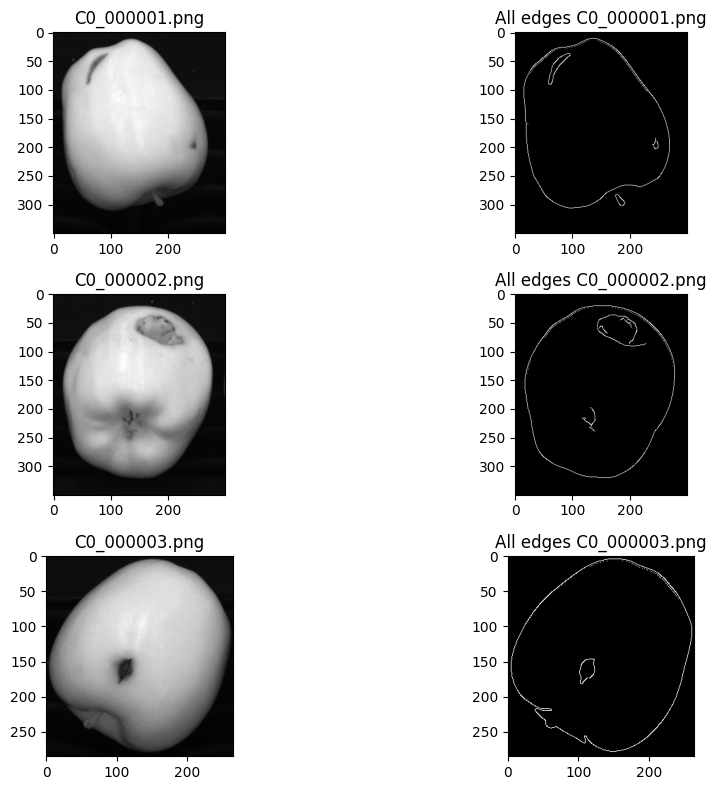

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(13, 8), gridspec_kw={'width_ratios': [1, 1]})

int_edge_dil_arr = []
for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path)
    g_blur = cv2.GaussianBlur(img,(9,9),0)
    #fruit_only1 = cv2.bitwise_and(g_blur, g_blur, mask=filled_th1_arr[0])
    mat = np.ones_like(img)*255
    fruit_only1 = cv2.bitwise_not(cv2.bitwise_and(mat, cv2.bitwise_not(g_blur), mask=th1_final_arr[i]))
    edge = cv2.Canny(fruit_only1, 10, 100)

    #Print images
    axs[i, 0].imshow(img), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(edge, cmap='gray'), axs[i, 1].set_title(f"All edges C0_00000{i+1}.png")

    plt.tight_layout()

Since the pixels being part of fruit edges have a gradient value higher than that being part of defects edges, we can run the Canny's detector twice to obtain all the edges and the external edges, then we subtract the external edges to isolate the internal ones.

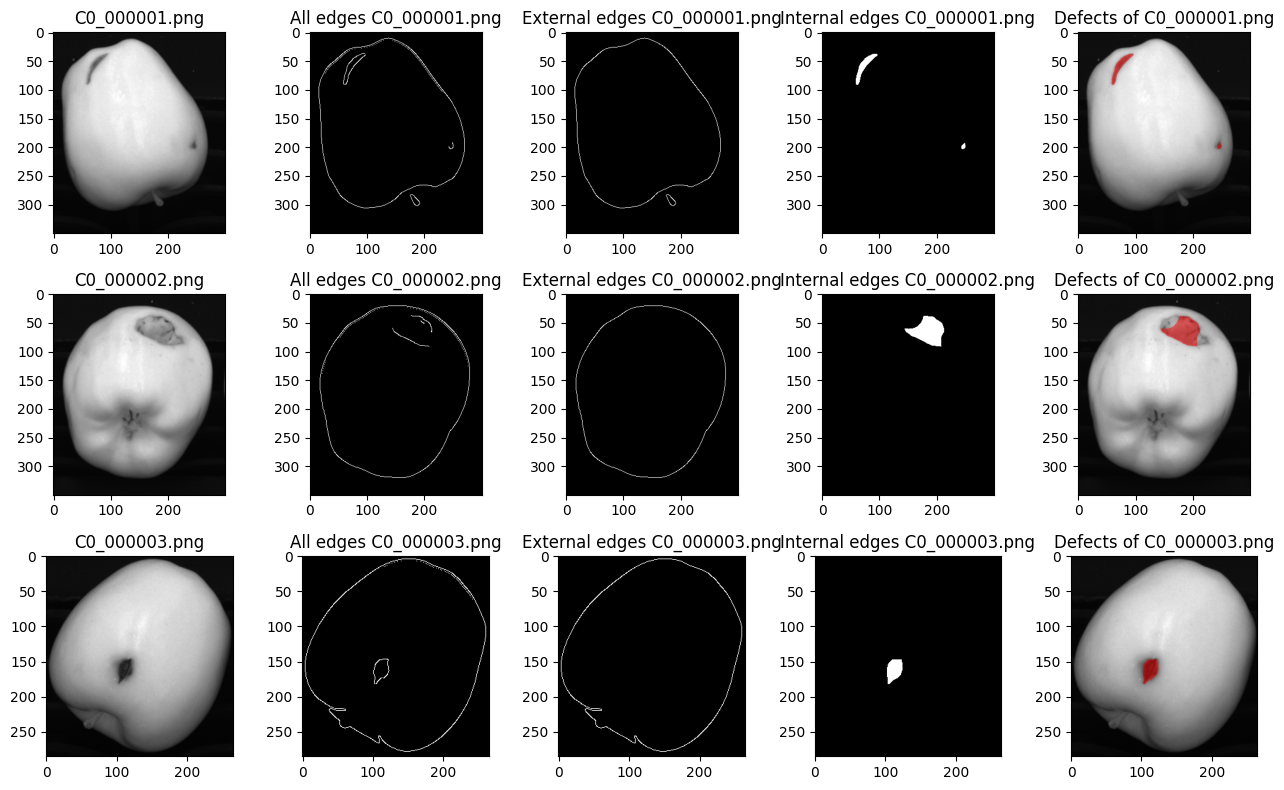

In [110]:
fig, axs = plt.subplots(3, 5, figsize=(13, 8), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})

int_edge_dil_arr = []
for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path)
    g_blur = cv2.GaussianBlur(img,(9,9),0)
    #fruit_only1 = cv2.bitwise_and(g_blur, g_blur, mask=filled_th1_arr[0])
    mat = np.ones_like(img)*255
    fruit_only1 = cv2.bitwise_not(cv2.bitwise_and(mat, cv2.bitwise_not(g_blur), mask=th1_final_arr[i]))
    ext_edge = cv2.Canny(fruit_only1, 200, 300)
    kernel = np.ones((10,10))
    ext_edge_dil = cv2.dilate(ext_edge, kernel, iterations=1)
    
    all_edge = cv2.Canny(fruit_only1, 80, 125)
    int_edge = cv2.bitwise_and(all_edge, all_edge, mask=cv2.bitwise_not(ext_edge_dil))
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50))
    int_edge_dil = cv2.morphologyEx(int_edge, cv2.MORPH_CLOSE, kernel)
    int_edge_dil_arr.append(int_edge_dil)

    # Crea un'immagine vuota del colore desiderato
    edge_color=(255, 0, 0)
    alpha = 0.5
    colored_edges = np.zeros_like(img)
    colored_edges[int_edge_dil == 255] = edge_color
    
    # Applica la sovrapposizione semi-trasparente
    defects = img.copy()
    mask_indices = int_edge_dil == 255  # Trova i pixel dove applicare l'overlay
    for c in range(3):  # Applica per ciascun canale (R, G, B)
        defects[..., c][mask_indices] = (
            (1 - alpha) * img[..., c][mask_indices] + alpha * colored_edges[..., c][mask_indices]
        ).astype(np.uint8)

    #Print images
    axs[i, 0].imshow(img), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(all_edge, cmap='gray'), axs[i, 1].set_title(f"All edges C0_00000{i+1}.png")
    axs[i, 2].imshow(ext_edge, cmap='gray'), axs[i, 2].set_title(f"External edges C0_00000{i+1}.png")
    axs[i, 3].imshow(int_edge_dil, cmap='gray'), axs[i, 3].set_title(f"Internal edges C0_00000{i+1}.png")
    axs[i, 4].imshow(defects, cmap='gray'), axs[i, 4].set_title(f"Defects of C0_00000{i+1}.png")

    plt.tight_layout()

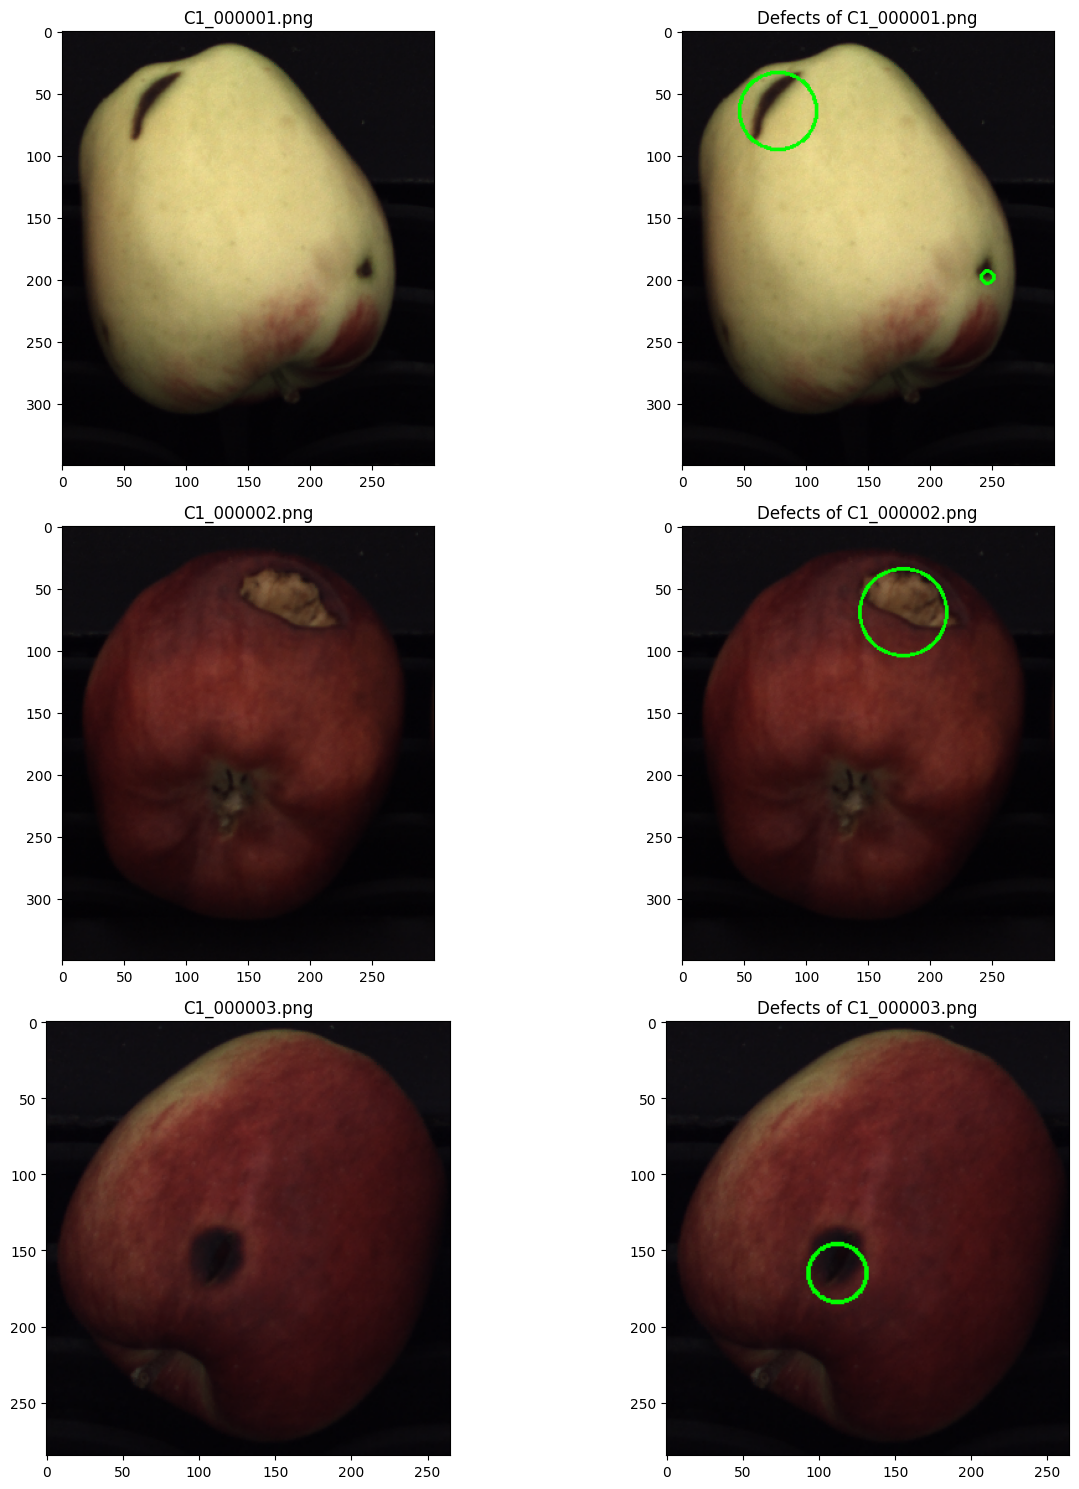

In [111]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15), gridspec_kw={'width_ratios': [1, 1]})
for i in range(3):
    path = f'./fruit-inspection-images/first task/C1_00000{i+1}.png'
    img = cv2.imread(path)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #defects = cv2.bitwise_and(image_rgb, image_rgb, mask=cv2.bitwise_not(int_edge_dil_arr[i]))
    defects = image_rgb.copy()

    contours, _ = cv2.findContours(int_edge_dil_arr[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (center_x, center_y), radius = cv2.minEnclosingCircle(contour)
        center = (int(center_x), int(center_y))
        radius = int(radius)
        # Draw on image
        cv2.circle(defects, center, radius, (0, 255, 0), 2)

    #Print images
    axs[i, 0].imshow(image_rgb), axs[i, 0].set_title(f"C1_00000{i+1}.png")
    axs[i, 1].imshow(defects), axs[i, 1].set_title(f"Defects of C1_00000{i+1}.png")

    plt.tight_layout()

#### We could create a binary mask through a manual thresholding. After few trial, we can see how a value of 30 can be an optimal value for threshold.

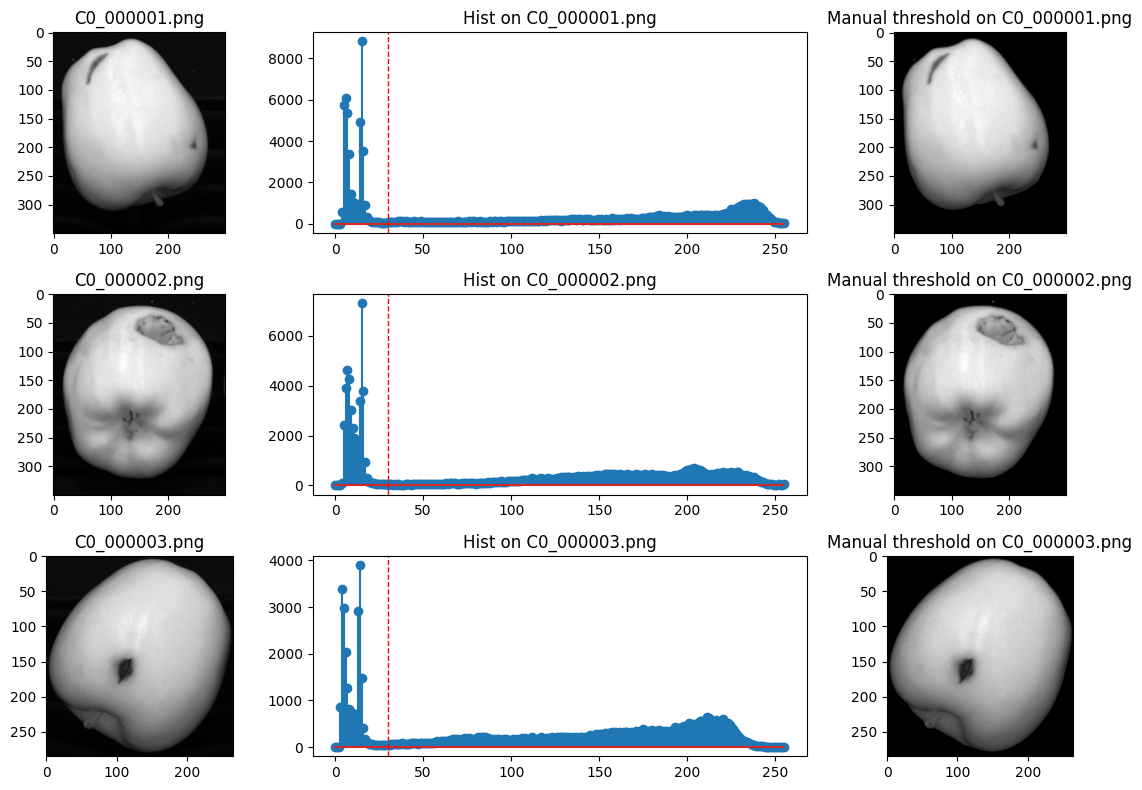

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5, 1]})

for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    g_blur = cv2.GaussianBlur(img,(9,9),0)

    #Apply Otsu's algorithm
    ret,th = cv2.threshold(g_blur,30,255,cv2.THRESH_BINARY)

    #fill background
    th = np.pad(th, 1, mode='constant', constant_values=255)
    cv2.floodFill(th, None, (0, 0), 0)
    th = th[1:-1, 1:-1]

    #Flood-fill the background with 255 (white)
    th_copy = th.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th_copy, mask, (0,0), 255)

    #Fill internal holes by overlapping results
    th_final = np.maximum(th, cv2.bitwise_not(th_copy))

    fruit_only = cv2.bitwise_and(img, img, mask=th_final)

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(img, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist), axs[i, 1].axvline(x=ret, color='r', linestyle='--', linewidth=1, label=f'x={ret}'),axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png")
    axs[i, 2].imshow(fruit_only, cmap='gray'), axs[i, 2].set_title(f"Manual threshold on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

#### We could lower the value found by Otsu's algorithm, but the value that has to be subtracted has to be found manually.

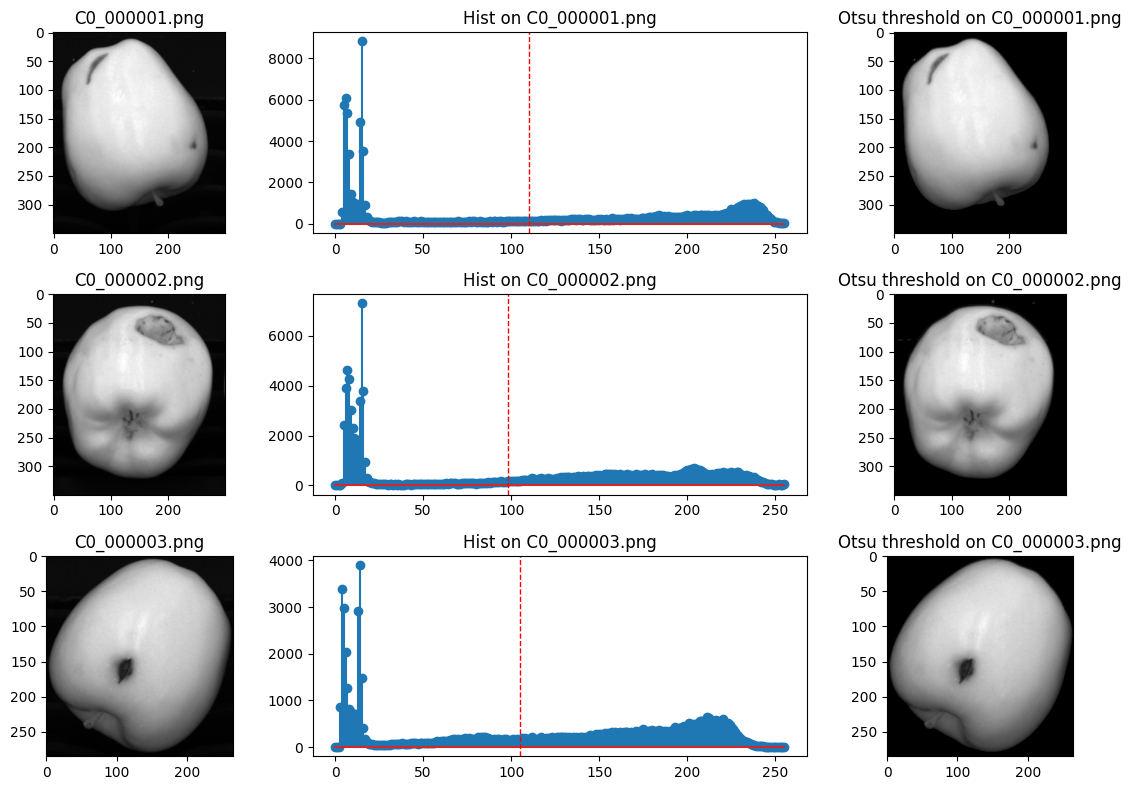

In [28]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5, 1]})

for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    g_blur = cv2.GaussianBlur(img,(9,9),0)

    #Apply Otsu's algorithm
    ret,th = cv2.threshold(g_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    adj_ret = max(ret-80, 0)

    _, adj_th = cv2.threshold(g_blur,adj_ret,255,cv2.THRESH_BINARY)

    #fill background
    adj_th = np.pad(adj_th, 1, mode='constant', constant_values=255)
    cv2.floodFill(adj_th, None, (0, 0), 0)
    adj_th = adj_th[1:-1, 1:-1]

    #Flood-fill the background with 255 (white)
    adj_th_copy = adj_th.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(adj_th_copy, mask, (0,0), 255)

    #Fill internal holes by overlapping results
    adj_th_final = np.maximum(adj_th, cv2.bitwise_not(adj_th_copy))

    fruit_only = cv2.bitwise_and(img, img, mask=adj_th_final)

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(img, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist), axs[i, 1].axvline(x=ret, color='r', linestyle='--', linewidth=1, label=f'x={ret}'),axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png")
    axs[i, 2].imshow(fruit_only, cmap='gray'), axs[i, 2].set_title(f"Otsu threshold on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

#### We could find the mean value on the entire image and then lower it by a certain value. This is the same method used by adaptive thresholding, but it is applied on the entire image. Since fruit image could exhibit some shadow or defects, we could have to deal with non-uniform light.

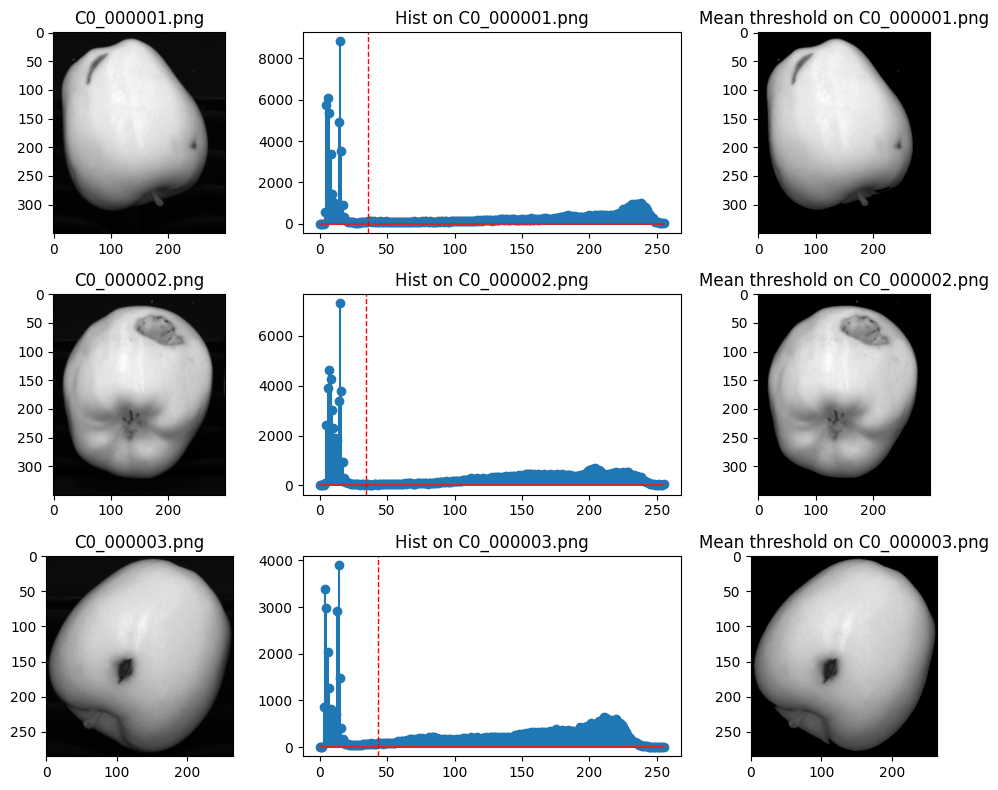

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 1.5, 1]})

for i in range(3):
    path = f'./fruit-inspection-images/first task/C0_00000{i+1}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    #Blur the image in order to smooth the border
    g_blur = cv2.GaussianBlur(img,(9,9),0)

    #Mean filtering
    ret,th = cv2.threshold(img,np.mean(g_blur)-70,255,cv2.THRESH_BINARY)

    #fill background
    th = np.pad(th, 1, mode='constant', constant_values=255)
    cv2.floodFill(th, None, (0, 0), 0)
    th = th[1:-1, 1:-1]

    #Flood-fill the background with 255 (white)
    th_copy = th.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th_copy, mask, (0,0), 255)

    #Fill internal holes by overlapping results
    th_final = np.maximum(th, cv2.bitwise_not(th_copy))

    fruit_only = cv2.bitwise_and(img, img, mask=th_final)

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(img, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist), axs[i, 1].axvline(x=ret, color='r', linestyle='--', linewidth=1, label=f'x={ret}'), axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png")
    axs[i, 2].imshow(fruit_only, cmap='gray'), axs[i, 2].set_title(f"Mean threshold on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    